### Сравнение средних значений (Дисперсионный анализ ANOVA)

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

 - В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные
 - Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

 
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп.
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.
10. Выберите формулу для модели, проведите тест.

Описание данных

5_task_1:

 * id – id клиента в эксперименте
 * group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
 * events – сколько блюд суммарно было заказано за период


5_task_2:

 * id – id клиента в эксперименте
 * segment – сегмент (high/low)
 * group – вид кнопки (control – старая версия, test – новая версия)
 * events – сколько блюд суммарно было заказано за период

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [5]:
url_1 = 'https://stepik.org/media/attachments/lesson/385920/5_task_1.csv'
url_2 = 'https://stepik.org/media/attachments/lesson/385920/5_task_2.csv'

data_1 = pd.read_csv(url_1)
data_2 = pd.read_csv(url_2)


In [6]:
data_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [7]:
data_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


1. Выберите метод, который предположительно подойдет в первом вопросе.

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9

B – квадратные

C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?


ANOVA - поскольку у нас 3 выборочные группы

2. Проверьте, являются ли дисперсии внутри групп гомогенными.


Гомогенность - примерно одинаковые дисперсии

H0 - разница между дисперсиями групп нет
H1 - разница между дисперсиями групп есть

In [8]:
stats.levene(data_1.query("group == 'A'").events,
             data_1.query("group == 'B'").events,
             data_1.query("group == 'C'").events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Поскольку pvalue > 0.05, то большой разницы между дисперсиями нет.

3. Проведите тест на нормальность распределения.


Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

H0 - данные распределены ненормально
H1 - данные распределены нормально

In [9]:
from scipy.stats import shapiro

Сначала сделаем без сэмплирования

In [94]:
for group in data_1.group.unique():
    print(f"Результаты для группы {group} с семплированием: ",
        shapiro(x=data_1.query(f"group == '{group}'").events.sample(n=1000, random_state=17))
        )

Результаты для группы A с семплированием:  ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
Результаты для группы B с семплированием:  ShapiroResult(statistic=0.9980818629264832, pvalue=0.3186272084712982)
Результаты для группы C с семплированием:  ShapiroResult(statistic=0.9981189966201782, pvalue=0.3360903561115265)


In [95]:
for group in data_1.group.unique():
    print(f"Результаты для группы {group} без семплирования: ",
        shapiro(x=data_1.query(f"group == '{group}'").events)
        )

Результаты для группы A без семплирования:  ShapiroResult(statistic=0.9989334344863892, pvalue=3.915170964319259e-06)
Результаты для группы B без семплирования:  ShapiroResult(statistic=0.9990164041519165, pvalue=1.0542044037720188e-05)
Результаты для группы C без семплирования:  ShapiroResult(statistic=0.9989203214645386, pvalue=3.3573114706086926e-06)


C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Заметно, что без семплирования p_value сильно искажается и не получается точного результата. 

Визуализируем распределение данных с помощью qq-plot

In [35]:
stats.probplot(data_1.query(f"group == 'A'")["events"], fit=True)
plt.show()

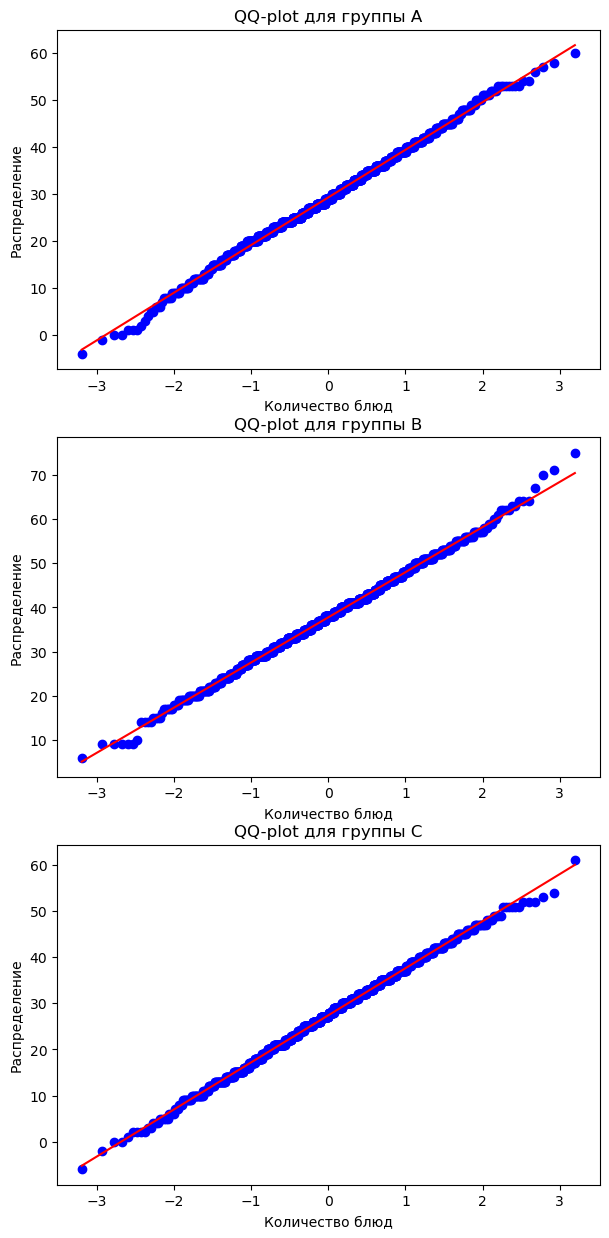

In [47]:
fig, ax = plt.subplots(3, 1 , figsize=(7, 15))

for i, group in enumerate(data_1["group"].unique()):
    stats.probplot(data_1.query(f"group == '{group}'")["events"].sample(1000, random_state=17), dist="norm", plot=ax[i])
    ax[i].set_title(f"QQ-plot для группы {group}")
    ax[i].set_xlabel("Количество блюд")
    ax[i].set_ylabel("Распределение")



Поскольку p-value при семплирование составляет < 0.05 => данные распределены нормально

4. Сравните средние в представленных группах.


Воспользуемся one-way ANOVA, поскольку у нас проверка по одному значению -  events

H0 - нет различий между средними в группах, H1 - есть различия между средними в группах

In [48]:
from scipy.stats import f_oneway

In [49]:
f_oneway(data_1.query("group == 'A'").events,
             data_1.query("group == 'B'").events,
             data_1.query("group == 'C'").events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Поскольку pvalue < 0.05 => различия между средними в группах есть (само значение statistic довольно велико - 2886)

5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.


In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [62]:
pairwise_tukeyhsd(endog=data_1.events, groups=data_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


* meandiff показывает разницу между средними значениями групп

* reject - опровергаем нулевую гипотезу или нет

Во всех группах видны статистически значимые различия: A и C, B и C, A и С

6. Примите решение: какие картинки в итоге будем использовать?


In [67]:
data_1.groupby("group").events.sum().sort_values(ascending=False)

group
B    376136
A    295796
C    274703
Name: events, dtype: int64

Больше всего совершенных event-ов у группы B - выбираем картинки квадратные

7. Выберите метод для второго теста.



In [68]:
data_2.head(2)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0


Поскольку мы смотрим на segment и group => у нас будет многофакторный ANOVA для сравнения средних значений

8. Визуализируйте распределение events для контрольной и тестовой групп.

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


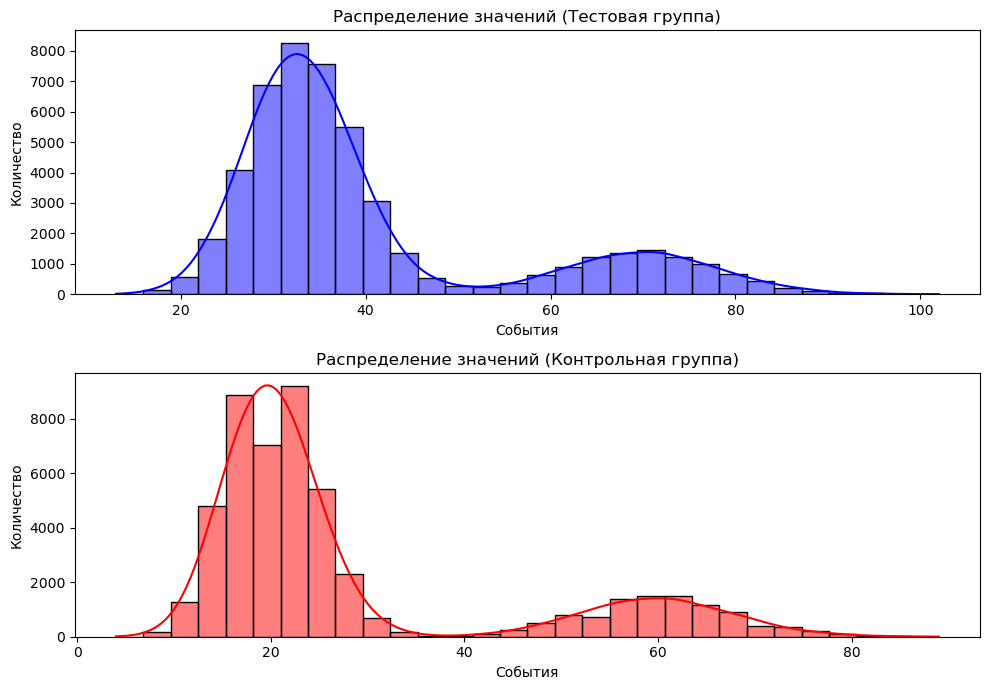

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

sns.histplot(data_2.query("group == 'test'").events, bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Распределение значений (Тестовая группа)")
axes[0].set_xlabel("События")
axes[0].set_ylabel("Количество")

sns.histplot(data_2.query("group == 'control'").events, bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Распределение значений (Контрольная группа)")
axes[1].set_xlabel("События")
axes[1].set_ylabel("Количество")

plt.tight_layout()
plt.show()

9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.


In [86]:
data_2.groupby(['group', 'segment']).agg({'events': 'sum'})

events
group   segment           
control high      599708.0
        low       801263.0
test    high      699385.0
        low      1321037.0

In [109]:
for gr in data_2.group.unique():
    for sg in data_2.segment.unique():
        print(f"Описательные статистики для группы {gr} и сегмента {sg}:\n",
            np.round(data_2.query(f"group == '{gr}' & segment == '{sg}'").events.agg(["mean", "std", "var"]), 2))

Описательные статистики для группы test и сегмента high:
 mean    69.94
std      8.40
var     70.63
Name: events, dtype: float64
Описательные статистики для группы test и сегмента low:
 mean    33.03
std      5.72
var     32.73
Name: events, dtype: float64
Описательные статистики для группы control и сегмента high:
 mean    59.97
std      7.81
var     60.92
Name: events, dtype: float64
Описательные статистики для группы control и сегмента low:
 mean    20.03
std      4.47
var     20.01
Name: events, dtype: float64


10. Выберите формулу для модели, проведите тест.

In [110]:
data_2.head(2)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0


Используем многофакторный ANOVA с формулой для OLS: 
- events ~ group + segment + group:segment

Перед использованием ANOVA проверим на: гомогенность и нормальность распределения данных

In [121]:
from itertools import product

In [123]:
comb = product(data_2.group.unique(), data_2.group.unique(), data_2.segment.unique(), data_2.segment.unique())

In [124]:
for gr1, gr2, sg1, sg2 in comb:
    if gr1 != gr2 and sg1 != sg2:  
        group1_data = data_2.query(f"group == '{gr1}' & segment == '{sg1}'").events
        group2_data = data_2.query(f"group == '{gr2}' & segment == '{sg2}'").events
        
        if len(group1_data) > 1 and len(group2_data) > 1:
            stat, p_value = stats.levene(group1_data, group2_data)
            
            print(f"Группа {gr1} и сегмент {sg1} vs Группа {gr2} и сегмент {sg2}, p-value: {p_value}")

Группа test и сегмент high vs Группа control и сегмент low, p-value: 0.0
Группа test и сегмент low vs Группа control и сегмент high, p-value: 0.0
Группа control и сегмент high vs Группа test и сегмент low, p-value: 0.0
Группа control и сегмент low vs Группа test и сегмент high, p-value: 0.0


In [126]:
for gr in data_2.group.unique():
    for sg in data_2.segment.unique():
        print(f"Тест Шапиро-Уилка для {gr} и {sg}:\n",
            shapiro(data_2.query(f"group == '{gr}' & segment == '{sg}'").events.sample(1000, random_state=17)))

Тест Шапиро-Уилка для test и high:
 ShapiroResult(statistic=0.9973599910736084, pvalue=0.10337314009666443)
Тест Шапиро-Уилка для test и low:
 ShapiroResult(statistic=0.9961868524551392, pvalue=0.014886144548654556)
Тест Шапиро-Уилка для control и high:
 ShapiroResult(statistic=0.9937261939048767, pvalue=0.00032940757228061557)
Тест Шапиро-Уилка для control и low:
 ShapiroResult(statistic=0.9905020594596863, pvalue=4.6439204197668005e-06)


Самые большие сомнения вызывают control-low, нужно обратить внимание на данную комбинацию групп (использовать корректировку Уэлча можно)

In [132]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [136]:
model_data_2 = smf.ols(formula="events ~ group + segment + group:segment", data=data_2).fit()
sm.stats.anova_lm(model_data_2, typ=2)

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Выводы:
* group и segment имеют статистически значимые влияния на 
* влияние одного фактора имеет значимость от другого фактора

Выясним какие группы взаимодействуют и влияют друг на друга - критерий Тьюки

In [137]:
pairwise_tukeyhsd(data_2.events, data_2.group + data_2.segment).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
controlhigh,controllow,-39.9392,0.0,-40.1073,-39.7711,True
controlhigh,testhigh,9.9677,0.0,9.7551,10.1803,True
controlhigh,testlow,-26.9449,0.0,-27.113,-26.7768,True
controllow,testhigh,49.9069,0.0,49.7388,50.075,True
controllow,testlow,12.9944,0.0,12.888,13.1007,True
testhigh,testlow,-36.9126,0.0,-37.0807,-36.7445,True


In [138]:
pairwise_tukeyhsd(data_2.events, data_2.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,test,12.389,0.0,12.185,12.593,True


In [139]:
pairwise_tukeyhsd(data_2.events, data_2.segment).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,low,-38.4259,0.0,-38.5583,-38.2935,True


* Все различия между группами значимы, потому что для всех пар p-value = 0.0, что указывает на статистическую значимость различий между средними.
* Статистически значимые различия присутствуют между контрольными и тестовыми группами, а также между различными уровнями в этих группах 

<Axes: xlabel='group', ylabel='events'>

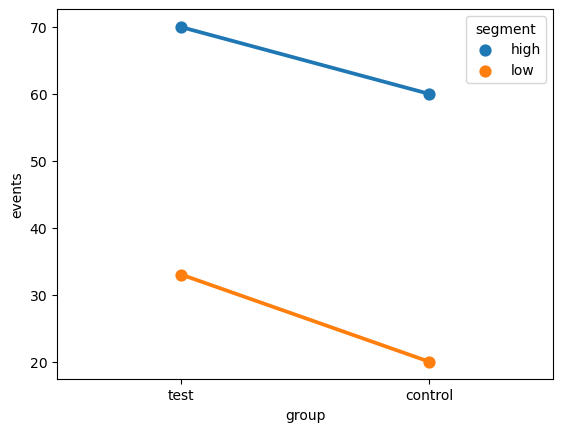

In [145]:
sns.pointplot(x='group', y='events', data=data_2, hue='segment')

<Axes: xlabel='segment', ylabel='events'>

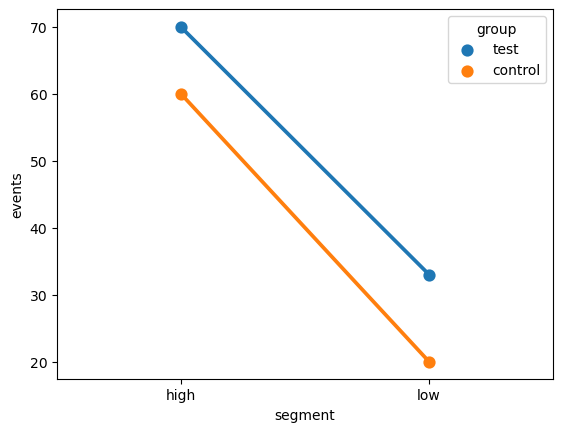

In [142]:
sns.pointplot(x='segment' , y='events' , data=data_2, hue='group')


Нужно использовать новую версию кнопки, поскольку увеличилось среднее взаимодействие на 10